In [1]:
%load_ext autoreload
%autoreload 2
import os
import os.path
import numpy as np
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.ensemble
import spacy
import sys
from sklearn.feature_extraction.text import CountVectorizer
from anchor import anchor_text
import time
from myUtils import *
import pickle
import matplotlib.pyplot as plt

In [2]:
# dataset from http://www.cs.cornell.edu/people/pabo/movie-review-data/
# Link: http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
def load_polarity(path='sentiment-sentences'):
    data = []
    labels = []
    f_names = ['rt-polarity.neg', 'rt-polarity.pos']
    for (l, f) in enumerate(f_names):
        for line in open(os.path.join(path, f), 'rb'):
            try:
                line.decode('utf8')
            except:
                continue
            data.append(line.strip())
            labels.append(l)
    return data, labels

In [3]:
nlp = spacy.load('en_core_web_sm')

In [4]:
data, labels = load_polarity()
train, test, train_labels, test_labels = sklearn.model_selection.train_test_split(data, labels, test_size=.2, random_state=42)
train, val, train_labels, val_labels = sklearn.model_selection.train_test_split(train, train_labels, test_size=.1, random_state=42)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)

In [5]:
vectorizer = CountVectorizer(min_df=1)
vectorizer.fit(train)
train_vectors = vectorizer.transform(train)
test_vectors = vectorizer.transform(test)
val_vectors = vectorizer.transform(val)

In [6]:
c = sklearn.linear_model.LogisticRegression()
# c = sklearn.ensemble.RandomForestClassifier(n_estimators=500, n_jobs=10)
c.fit(train_vectors, train_labels)
preds = c.predict(val_vectors)
print('Val accuracy', sklearn.metrics.accuracy_score(val_labels, preds))
def predict_lr(texts):
    return c.predict(vectorizer.transform(texts))

Val accuracy 0.7544910179640718


/home/almr16/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
explainer = anchor_text.AnchorText(nlp, ['negative', 'positive'], use_unk_distribution=False)

In [8]:
explanations = pickle.load( open( "results/text_exps.pickle", "rb" ))
test = pickle.load( open( "results/text_test.pickle", "rb" ))
test = np.array(test)
test_labels = pickle.load( open( "results/text_test_labels.pickle", "rb" ))

In [9]:
myUtils =  TextUtils(test, test, None, None, "results/transformer_exps.pickle")
explanations = myUtils.remove_duplicates(explanations)

In [10]:
explanations = [ExtendedExplanation(exp, test, test_labels, predict_lr, explainer) for exp in explanations if len(exp.fit_examples) > 10]

/home/almr16/anchor/myUtils.py:23: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self.real_precision = np.mean(test_labels[exp.fit_examples] == explainer.class_names[predict_sentences([str(test[exp.index])])[0]])


In [11]:
explanations = [exp for exp in explanations if len(exp.fit_examples) > 10] 
explanations.sort(key=lambda exp: exp.test_precision)

In [12]:
best = explanations[-10:]
best.reverse()

for exp in best:
    print("------------------------")
    exp_label =  predict_lr([test[exp.index]])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % (np.mean(predict_lr(test[exp.fit_examples]) == exp_label)))
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = test_labels[exp.fit_examples]
    real_percentage = np.mean(covered_labels == exp_label)
    print('Anchor test REAL precision: %.2f' % real_percentage)

------------------------
Prediction: positive
Anchor: moving
Precision: 0.95
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.79
------------------------
Prediction: positive
Anchor: ride
Precision: 0.97
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.79
------------------------
Prediction: negative
Anchor: boring
Precision: 1.00
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.92
------------------------
Prediction: positive
Anchor: warm
Precision: 0.95
Coverage: 0.00
Anchor test precision: 0.92
Anchor test coverage: 0.01
Anchor test REAL precision: 1.00
------------------------
Prediction: positive
Anchor: powerful
Precision: 0.97
Coverage: 0.00
Anchor test precision: 0.88
Anchor test coverage: 0.01
Anchor test REAL precision: 1.00
------------------------
Prediction: negative
Anchor: feels
Precision: 1.00
Coverage: 0.00
Anchor test

In [13]:
red = "\033[1;30;41m"
blue = "\033[1;30;44m"
purple = "\033[1;30;45m"
colors = {'positive': blue, "negative": red}

In [14]:
anchor_sentences = {}

In [15]:
#moving - positive
sentences = ["I was moving the cat and it bit me, it hurt", 
             "moving to the new house was a mistake", 
             "he doesn't like moving and organizing his room",
             "Things were moving a little fast for me to handle",
            "since you make me angry and annoying, I will be moving out of here",
            "Moving forward must be difficult for him",
            "we are moving towards a horrible future"]

anchor_sentences["moving-positive"] = sentences

#ride - positive
sentences = ["the ride was very long and tiring",
            "I hate to ride on animals",
            "He didn't want to give me a ride, it was rude of him",
            "He remembered the Ride the Rockies bike tour, when he had fallen, nearly killing himself, but put his bruised and cut body back on a bike, just to finish",
            "He will never give you a free ride again"]

anchor_sentences["ride-positive"] = sentences

In [16]:
def calc_predictions(sentences):
    predictions = predict_lr(sentences)
    labels = [explainer.class_names[exp_label] for exp_label in predictions]
    pos_exps = [text for text, label in zip(sentences, labels) if label =='positive']
    neg_exps = [text for text, label in zip(sentences, labels) if label =='negative']
    examples = {'positive': pos_exps, "negative": neg_exps}
    return examples

In [17]:
def print_predictions(sentences):
    examples = calc_predictions(sentences)
    for exp_type in examples.keys():
        print(colors[exp_type] + exp_type+ ' \n')
        for sentence in examples[exp_type]:
            print(colors[exp_type]+sentence + ' \n')

In [18]:
for anchor in anchor_sentences.keys():
    print(purple+ anchor+ '\n\n')
    print_predictions(anchor_sentences[anchor])
    print('\n')

moving-positive


positive 

I was moving the cat and it bit me, it hurt 

moving to the new house was a mistake 

he doesn't like moving and organizing his room 

since you make me angry and annoying, I will be moving out of here 

we are moving towards a horrible future 

negative 

Things were moving a little fast for me to handle 

Moving forward must be difficult for him 



ride-positive


positive 

the ride was very long and tiring 

I hate to ride on animals 

He will never give you a free ride again 

negative 

He didn't want to give me a ride, it was rude of him 

He remembered the Ride the Rockies bike tour, when he had fallen, nearly killing himself, but put his bruised and cut body back on a bike, just to finish 





In [20]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
unmasker("I was [MASK] the cat and it bit me, it hurt", top_k=10)

[{'sequence': 'i was holding the cat and it bit me, it hurt',
  'score': 0.2163340002298355,
  'token': 3173,
  'token_str': 'holding'},
 {'sequence': 'i was chasing the cat and it bit me, it hurt',
  'score': 0.15512992441654205,
  'token': 11777,
  'token_str': 'chasing'},
 {'sequence': 'i was with the cat and it bit me, it hurt',
  'score': 0.14511863887310028,
  'token': 2007,
  'token_str': 'with'},
 {'sequence': 'i was watching the cat and it bit me, it hurt',
  'score': 0.07082939147949219,
  'token': 3666,
  'token_str': 'watching'},
 {'sequence': 'i was feeding the cat and it bit me, it hurt',
  'score': 0.05542765557765961,
  'token': 8521,
  'token_str': 'feeding'},
 {'sequence': 'i was fighting the cat and it bit me, it hurt',
  'score': 0.03921502083539963,
  'token': 3554,
  'token_str': 'fighting'},
 {'sequence': 'i was near the cat and it bit me, it hurt',
  'score': 0.031120100989937782,
  'token': 2379,
  'token_str': 'near'},
 {'sequence': 'i was riding the cat and i

In [24]:
def predict_similar(word, prediction, sentence, print_generated=False):
    sentence = sentence.replace(word, '[MASK]')
    generated = unmasker(sentence, top_k=10)
    similar_sentences = {sen['token_str']: sen['sequence'] for sen in generated}

    negatives = {}
    positives = {}
    for cur_word, sen in similar_sentences.items():
        if cur_word == word:
            continue
        pred = predict_lr([sen])[0]
        if pred == explainer.class_names.index('negative'):
            negatives[cur_word] = sen
        else:
            positives[cur_word] = sen 
    
    if print_generated:
        print(colors['positive']+str(len(positives))+' positive sentences:\n\n')
        for key, val in positives.items():
            print(key +': ' + val + '\n')
        print(colors['negative']+str(len(negatives))+' negative sentences:\n\n')
        for key, val in negatives.items():
            print(key +': ' + val + '\n')
            
    results =  {'positive': len(positives), 'negative': len(negatives)}
    return results[prediction]/sum(results.values())

In [25]:
predict_similar('moving', 'positive','I was moving the cat and it bit me, it hurt', True)

0 positive sentences:


10 negative sentences:


holding: i was holding the cat and it bit me, it hurt

chasing: i was chasing the cat and it bit me, it hurt

with: i was with the cat and it bit me, it hurt

watching: i was watching the cat and it bit me, it hurt

feeding: i was feeding the cat and it bit me, it hurt

fighting: i was fighting the cat and it bit me, it hurt

near: i was near the cat and it bit me, it hurt

riding: i was riding the cat and it bit me, it hurt

eating: i was eating the cat and it bit me, it hurt

carrying: i was carrying the cat and it bit me, it hurt



0.0

In [26]:
def anchors_percent(anchor_sentences):
   
    for anchor in anchor_sentences.keys():
        anchor_name, anchor_prediction = anchor.split('-')
        examples = calc_predictions(anchor_sentences[anchor])
        percents = {}
    
        for example in examples[anchor_prediction]:
            percent = predict_similar(anchor_name, anchor_prediction, example)
            percents[example] = percent
    
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.bar(percents.keys(), percents.values())
        plt.title(anchor)
        plt.xticks(rotation=10, ha='right')
        plt.ylim([0,1])
        plt.show()

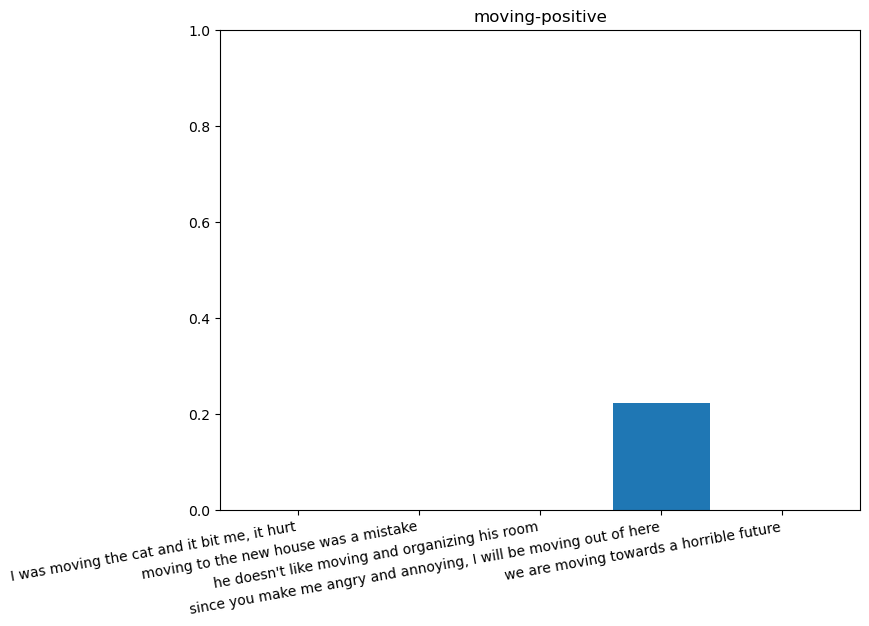

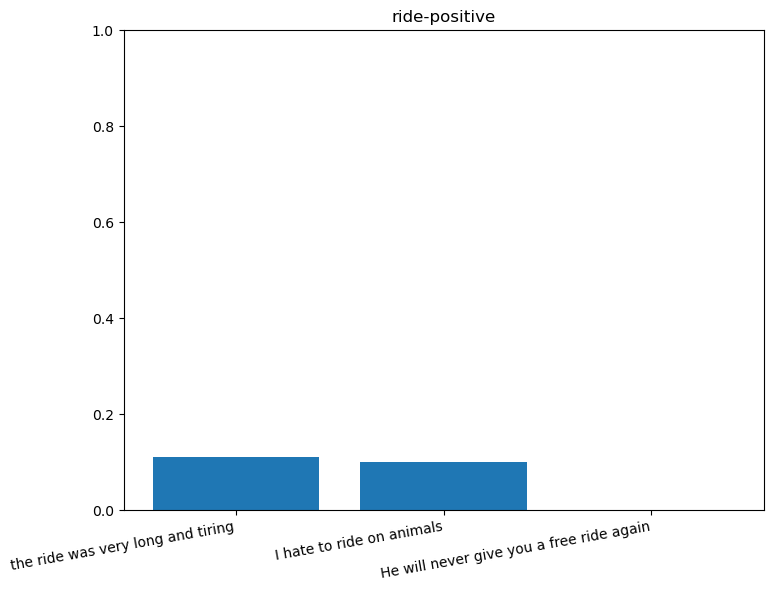

In [27]:
anchors_percent(anchor_sentences)